In [71]:

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

In [72]:
df = pd.read_csv('./data/stock.csv')

In [73]:
df.dtypes

Date      object
Open       int64
High       int64
Low        int64
Volume     int64
Close      int64
dtype: object

In [74]:
class StockDataset(Dataset):
    def __init__(self, csv_file, window_size):
        self.data = pd.read_csv(csv_file)
        
        # self.data['Date'] = self.data.index.tolist()
        self.data = self.data[self.data.columns[1:]]
        self.data_mean = self.data.mean()
        self.data_std = self.data.std()
        self.datanormal = (self.data - self.data_mean) / self.data_std
        self.window_size = window_size
        
    def __len__(self):
        return len(self.datanormal) - self.window_size
    
    def __getitem__(self, idx):
        window = self.datanormal.iloc[idx:idx+self.window_size][self.data.columns[0:-1]]
        target = self.datanormal.iloc[idx+self.window_size]['Close']
        return torch.tensor(window.values, dtype=torch.float32, device=device), torch.tensor(target, dtype=torch.float32, device=device)

WINDOW = 20
data = StockDataset('./data/stock.csv', WINDOW)


In [75]:
train_split = Subset(data, range(int(len(data) * 0.8)))
test_split = Subset(data, range(int(len(data) * 0.8), len(data)))



In [76]:
train_split.indices.__len__(), test_split.indices.__len__()

(757, 190)

In [77]:
trainloader = DataLoader(train_split, batch_size=WINDOW * 10, shuffle=False, drop_last=False)
testloader = DataLoader(test_split, batch_size=WINDOW * 10, shuffle=False, drop_last=False)


In [78]:
class RnnModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.numlayer = 10
        self.bidirectional = False
        self.multiplyer = 2 if self.bidirectional else 1
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=self.numlayer, batch_first=True, bidirectional=self.bidirectional)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(self.multiplyer * hidden_size * self.numlayer, output_size)
        # self.fc1 = nn.Linear(self.multiplyer * hidden_size, output_size)
        self.flatten = nn.Flatten()
        self.init_weights()

    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'bias' in name:
                 nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                 nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                 nn.init.orthogonal_(param)
    
    
    def forward(self, x):
        h0 = torch.zeros(self.numlayer * self.multiplyer, x.size(0), self.hidden_size).requires_grad_()
        c0 = torch.zeros(self.numlayer * self.multiplyer, x.size(0), self.hidden_size).requires_grad_()
        x, (hn, cn) = self.lstm(x)
        # print(hn.shape)
        # print(x.shape)
        x = hn.permute(1, 0, 2).reshape(x.size(0), -1)
        x = self.fc1(x)
        # x = self.fc1(x[:, -1, :])
        # x = self.relu(x)
        # x = self.fc2(x)
        # x = self.flatten(x)
        # print(x.shape)
        return nn.Flatten()(x)
    
criteria = nn.MSELoss().to(device=device)
model = RnnModel(4, 64, 1).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)

        
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10)


In [79]:
from torchmetrics.regression import MeanSquaredError, R2Score

def train(model, trainloader, criterion, optimizer):
    model.train()
    running_loss = []
    mse = MeanSquaredError().to(device)
    r2 = R2Score().to(device)
    
    for i, data in enumerate(trainloader):
        inputs, labels = data
        labels = labels.unsqueeze(1)
        # print(inputs.shape)
        result = model(inputs)
        
        loss = criterion(result, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss.append(loss.cpu().item())
        mse(result, labels)
        r2(result, labels)
    
    return np.mean(running_loss), mse.compute().cpu().item(), r2.compute().cpu().item()


def test(model, testloader, criterion):
    model.eval()
    running_loss = []
    mse = MeanSquaredError().to(device)
    r2 = R2Score().to(device)
    
    with torch.no_grad():
        for i, data in enumerate(testloader):
            inputs, labels = data
            labels = labels.unsqueeze(1)
            result = model(inputs)
            
            loss = criterion(result, labels)
            
            running_loss.append(loss.cpu().item())
            mse(result, labels)
            r2(result, labels)
    
    return np.mean(running_loss), mse.compute().cpu().item(), r2.compute().cpu().item()

In [80]:

EPOCHES = 200

train_losses = []
test_losses = []
train_mseList = []
test_mseList = []
train_r2List = []
test_r2List = []

for epoch in range(EPOCHES):
    train_loss, train_mse, train_r2 = train(model, trainloader, criteria, optimizer)
    test_loss, test_mse, test_r2 = test(model, testloader, criteria)
    

    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_mseList.append(train_mse)
    test_mseList.append(test_mse)
    train_r2List.append(train_r2)
    test_r2List.append(test_r2)
    
    print(f'Epoch {epoch+1}/{EPOCHES}')
    print(f'Train r2: {train_r2:.4f}')
    print(f'Test r2: {test_r2:.4f}')
    print(f'Test Loss: {test_loss:.4f}')

    scheduler.step(test_loss)
    if scheduler.num_bad_epochs > scheduler.patience:
        print('Early stop')
        break

Epoch 1/200
Train r2: 0.3888
Test r2: 0.4425
Test Loss: 0.0607
Epoch 2/200
Train r2: 0.6348
Test r2: -2.1045
Test Loss: 0.3383
Epoch 3/200
Train r2: 0.7320
Test r2: -0.7271
Test Loss: 0.1882
Epoch 4/200
Train r2: 0.5959
Test r2: -0.9778
Test Loss: 0.2155
Epoch 5/200
Train r2: 0.9179
Test r2: 0.7131
Test Loss: 0.0313
Epoch 6/200
Train r2: 0.9584
Test r2: 0.7091
Test Loss: 0.0317
Epoch 7/200
Train r2: 0.9558
Test r2: 0.7979
Test Loss: 0.0220
Epoch 8/200
Train r2: 0.9713
Test r2: 0.8706
Test Loss: 0.0141
Epoch 9/200
Train r2: 0.9865
Test r2: 0.8958
Test Loss: 0.0114
Epoch 10/200
Train r2: 0.9805
Test r2: 0.8715
Test Loss: 0.0140
Epoch 11/200
Train r2: 0.9865
Test r2: 0.8943
Test Loss: 0.0115
Epoch 12/200
Train r2: 0.9914
Test r2: 0.8943
Test Loss: 0.0115
Epoch 13/200
Train r2: 0.9913
Test r2: 0.9034
Test Loss: 0.0105
Epoch 14/200
Train r2: 0.9922
Test r2: 0.9031
Test Loss: 0.0106
Epoch 15/200
Train r2: 0.9927
Test r2: 0.9166
Test Loss: 0.0091
Epoch 16/200
Train r2: 0.9935
Test r2: 0.9086


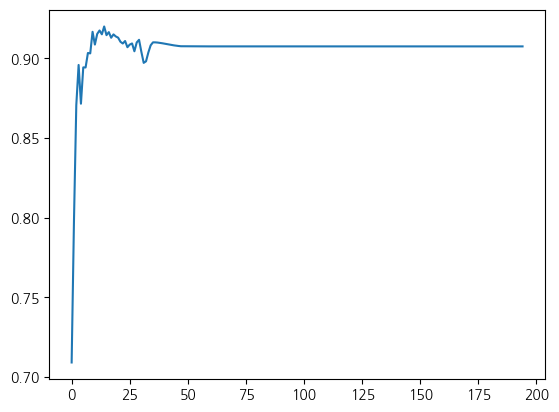

In [85]:
plt.plot(test_r2List[5:], label='train loss')

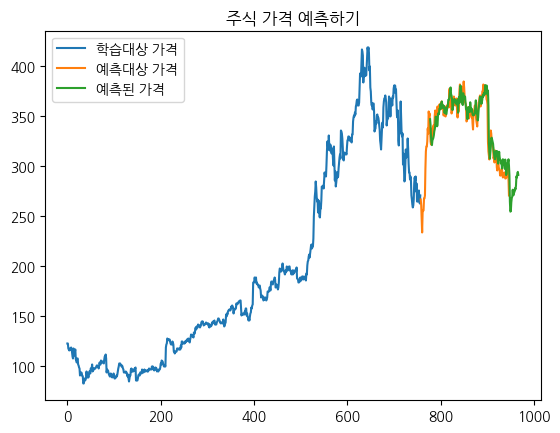

In [82]:
import koreanize_matplotlib

with torch.no_grad():
    for i, testdata in enumerate(testloader):
        inputs, labels = testdata
        labels = labels.unsqueeze(1)
        result = model(inputs)
result_predict = result.cpu().numpy().reshape(-1) * data.data_std['Close'] + data.data_mean['Close']
plt.title('주식 가격 예측하기')
plt.plot(train_split.dataset.data['Close'][train_split.indices], label='학습대상 가격')
plt.plot(test_split.dataset.data['Close'][test_split.indices], label='예측대상 가격')
plt.plot(pd.DataFrame(result_predict, index=test_split.dataset.data['Close'][test_split.indices].index+20), label='예측된 가격')
plt.legend()